In [1]:
import ROOT as r
import ctypes
import numpy as np
from array import array
import root_numpy as rn
import matplotlib.pyplot as plt
import pickle
import math

from tools.data_processing import *
from tools.kinematics import *

/home/hep/davide/miniconda3/envs/root_env/lib/ROOT.py:301: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return _orig_ihook( name, *args, **kwds )


In [2]:
masses = {
            'Ds': 1.968,
            'Dplus':1.869,
            'pi':0.140,
            'mu_plus': 0.105,
            'mu_minus': 0.105,
            'e_plus': 0.0005,
            'e_minus': 0.0005,
}

In [3]:
l_index =0
meson_index=0
mother_index = None
data_index = None 

# RETRIEVE DESIRED DATA

In [4]:
mother_ID=['Ds','Dplus']
meson_ID =['pi','X']
l_flv = ['e','mu']

data_type = ['MC','data']

def find_file_path(l_index=l_index, meson_index=meson_index, mother_index=mother_index, data_index=data_index): 
    if data_index == 0:
        return "/disk/lhcb_data/davide/Rphipi/"+data_type[data_index]+"/"+mother_ID[mother_index]+"_phipi_"+l_flv[l_index]+l_flv[l_index]+"/"+mother_ID[mother_index]+"_"+l_flv[l_index]+l_flv[l_index]+meson_ID[meson_index]+".root"
    else:
        return "/disk/lhcb_data/davide/Rphipi/"+data_type[data_index]+"/"+mother_ID[mother_index]+"_phipi_"+l_flv[l_index]+l_flv[l_index]+"/"+mother_ID[mother_index]+"_phi"+meson_ID[meson_index]+"_"+l_flv[l_index]+l_flv[l_index]+".root"
mother_index=0

data = r.TFile(find_file_path(l_index=l_index, mother_index=mother_index, data_index=1))
MC_Ds = r.TFile(find_file_path(l_index=l_index, mother_index=mother_index, data_index=0))

tree_name_Ds = mother_ID[mother_index]+'_OfflineTree/DecayTree'

t_data = data.Get(tree_name_Ds)
t_MC_Ds = MC_Ds.Get(tree_name_Ds)


mother_index=1

MC_Dplus = r.TFile(find_file_path(l_index=l_index, meson_index=meson_index, mother_index=mother_index, data_index=0))

tree_name_Dplus = mother_ID[mother_index]+'_OfflineTree/DecayTree'
t_MC_Dplus = MC_Dplus.Get(tree_name_Dplus)

#Switch on only the branches that you need
t_data.SetBranchStatus("*",0)
t_MC_Dplus.SetBranchStatus("*",0)
t_MC_Ds.SetBranchStatus("*",0)


for branch in return_branches(data_index=0, mother_index=0, l_index=l_index, meson_index=0):
    t_MC_Ds.SetBranchStatus(branch, 1)

for branch in return_branches(data_index=0, mother_index=1, l_index=l_index, meson_index=0):
    t_MC_Dplus.SetBranchStatus(branch, 1)
    
for branch in return_branches(data_index=1, mother_index=1, l_index=l_index, meson_index=0):    
    t_data.SetBranchStatus(branch, 1)
#Create a dictionary

#dict ={'branch_name'=[branch_value[event]]}

MC_Ds_tuple_dict = {}
branches_needed=return_branches(data_index=0, mother_index=0, l_index=l_index, meson_index=0)
for branch in branches_needed:
    
    MC_Ds_tuple_dict[branch] = rn.root2array(
        
        filenames=find_file_path(l_index, mother_index=0, data_index=0),
        treename = tree_name_Ds,
        branches = branch,
        start=0,
        stop=t_MC_Ds.GetEntries(),
    )
    
MC_Dplus_tuple_dict = {}
branches_needed=return_branches(data_index=0, mother_index=1, l_index=l_index, meson_index=0)
for branch in branches_needed:
    
    MC_Dplus_tuple_dict[branch] = rn.root2array(
        
        filenames=find_file_path(l_index, mother_index=1, data_index=0),
        treename = tree_name_Dplus,
        branches = branch,
        start=0,
        stop=t_MC_Dplus.GetEntries(),
    )
    
data_tuple_dict = {}

branches_needed=return_branches(data_index=1, mother_index=0, l_index=l_index, meson_index=0)
for branch in branches_needed:
    
    data_tuple_dict[branch] = rn.root2array(
        
        filenames=find_file_path(l_index,mother_index=0, data_index=1),
        treename = tree_name_Ds,
        branches = branch,
        start=0,
        stop=t_data.GetEntries(),
    )

# HLT and PID Preselection

In [101]:
#HLT1 PRESELECTION
data_tuple_dict_presel_1={}
MC_Ds_tuple_dict_presel_1={}
MC_Dplus_tuple_dict_presel_1={}


for label in return_branches(data_index=1, mother_index=0, l_index=l_index, meson_index=0):  
    data_tuple_dict_presel_1[label] = data_tuple_dict[label][data_tuple_dict["Ds_Hlt1TrackMVADecision_TOS"]]
    
for label in return_branches(data_index=0, mother_index=0, l_index=l_index, meson_index=0):      
    MC_Ds_tuple_dict_presel_1[label] = MC_Ds_tuple_dict[label][MC_Ds_tuple_dict["Ds_Hlt1TrackMVADecision_TOS"]]

for label in return_branches(data_index=0, mother_index=1, l_index=l_index, meson_index=0): 
    MC_Dplus_tuple_dict_presel_1[label] = MC_Dplus_tuple_dict[label][MC_Dplus_tuple_dict["Dplus_Hlt1TrackMVADecision_TOS"]]

#RareCharm D2pi l l HLT2 PRESELECTION

data_tuple_dict_presel_2={}
MC_Ds_tuple_dict_presel_2={}
MC_Dplus_tuple_dict_presel_2={}

for label in return_branches(data_index=1, mother_index=0, l_index=l_index, meson_index=0):
    data_tuple_dict_presel_2[label] = data_tuple_dict_presel_1[label][data_tuple_dict_presel_1["Ds_Hlt2RareCharmD2Pi"+l_flv[l_index].capitalize()+l_flv[l_index].capitalize()+"OSDecision_TOS"]]

for label in return_branches(data_index=0, mother_index=0, l_index=l_index, meson_index=0):
    MC_Ds_tuple_dict_presel_2[label] = MC_Ds_tuple_dict_presel_1[label][MC_Ds_tuple_dict_presel_1["Ds_Hlt2RareCharmD2Pi"+l_flv[l_index].capitalize()+l_flv[l_index].capitalize()+"OSDecision_TOS"]]

for label in return_branches(data_index=0, mother_index=1, l_index=l_index, meson_index=0):    
    MC_Dplus_tuple_dict_presel_2[label] = MC_Dplus_tuple_dict_presel_1[label][MC_Dplus_tuple_dict_presel_1["Dplus_Hlt2RareCharmD2Pi"+l_flv[l_index].capitalize()+l_flv[l_index].capitalize()+"OSDecision_TOS"]]

#PID preselection

#MC_PID_indices=np.where(MC_tuple_dict_presel_2[l_flv[l_index]+"_plus_MC15TuneV1_ProbNN"+l_flv[l_index]]>0.4)

data_PID_indices_plus=np.where(data_tuple_dict_presel_2[l_flv[l_index]+"_plus_MC15TuneV1_ProbNN"+l_flv[l_index]]>0.4)
data_PID_indices_minus=np.where(data_tuple_dict_presel_2[l_flv[l_index]+"_minus_MC15TuneV1_ProbNN"+l_flv[l_index]]>0.4)
data_PID_indices_pi=np.where(data_tuple_dict_presel_2["pi_MC15TuneV1_ProbNNpi"]>0.4)

data_PID_indices = np.intersect1d(data_PID_indices_plus,data_PID_indices_minus)
data_PID_indices = np.intersect1d(data_PID_indices,data_PID_indices_pi)
data_tuple_dict_presel_3={}
MC_Ds_tuple_dict_presel_3={}
MC_Dplus_tuple_dict_presel_3={}

for label in return_branches(data_index=1, mother_index=0, l_index=l_index, meson_index=0):
    data_tuple_dict_presel_3[label] = data_tuple_dict_presel_2[label][data_PID_indices]
    
for label in return_branches(data_index=0, mother_index=0, l_index=l_index, meson_index=0):    
    MC_Ds_tuple_dict_presel_3[label] = MC_Ds_tuple_dict_presel_2[label]#[MC_PID_indices]
    
for label in return_branches(data_index=0, mother_index=1, l_index=l_index, meson_index=0):
    MC_Dplus_tuple_dict_presel_3[label] = MC_Dplus_tuple_dict_presel_2[label]#[MC_PID_indices]

# BKGCAT and True ID preselection for MC Ds

In [102]:
#Getting rid of MC Background using BKG_CAT in MC Ds
#Keeping only low mass and ghost background
MC_Ds_indices=np.where(MC_Ds_tuple_dict_presel_3["Ds_BKGCAT"]<65)[0]

MC_Ds_tuple_dict_presel_4={}

for label in return_branches(data_index=0, mother_index=0, l_index=l_index, meson_index=0):  
    MC_Ds_tuple_dict_presel_4[label] = MC_Ds_tuple_dict_presel_3[label][MC_Ds_indices]
    
#No reflection
MC_Ds_indices=np.where(MC_Ds_tuple_dict_presel_4["Ds_BKGCAT"]!=30)

MC_Ds_tuple_dict_presel_5={}

for label in return_branches(data_index=0, mother_index=0, l_index=l_index, meson_index=0):  
    MC_Ds_tuple_dict_presel_5[label] = MC_Ds_tuple_dict_presel_4[label][MC_Ds_indices]
    

#No partially reconstructed
MC_Ds_indices=np.where(MC_Ds_tuple_dict_presel_5["Ds_BKGCAT"]!=40)

MC_Ds_tuple_dict_presel_6={}

for label in return_branches(data_index=0, mother_index=0, l_index=l_index, meson_index=0):  
    MC_Ds_tuple_dict_presel_6[label] = MC_Ds_tuple_dict_presel_5[label][MC_Ds_indices]

#Getting rid of MC Background matching mother IDs
MC_Ds_indices=np.where(np.abs(MC_Ds_tuple_dict_presel_6["pi_MC_MOTHER_ID"])==431)[0]

MC_Ds_tuple_dict_presel_7={}

for label in return_branches(data_index=0, mother_index=0, l_index=l_index, meson_index=0):  
    MC_Ds_tuple_dict_presel_7[label] = MC_Ds_tuple_dict_presel_6[label][MC_Ds_indices]
    
MC_Ds_indices=np.where(np.abs(MC_Ds_tuple_dict_presel_7[l_flv[l_index]+"_plus_MC_MOTHER_ID"])==333)

MC_Ds_tuple_dict_presel_8={}
for label in return_branches(data_index=0, mother_index=0, l_index=l_index, meson_index=0):  
    MC_Ds_tuple_dict_presel_8[label] = MC_Ds_tuple_dict_presel_7[label][MC_Ds_indices]

# BKGCAT and True ID preselection for MC Dplus

In [103]:
#Getting rid of MC Background using BKG_CAT in MC Ds
#Keeping only low mass and ghost background
MC_Dplus_indices=np.where(MC_Dplus_tuple_dict_presel_3["Dplus_BKGCAT"]<65)[0]

MC_Dplus_tuple_dict_presel_4={}

for label in return_branches(data_index=0, mother_index=1, l_index=l_index, meson_index=0):  
    MC_Dplus_tuple_dict_presel_4[label] = MC_Dplus_tuple_dict_presel_3[label][MC_Dplus_indices]
    
#No reflection
MC_Dplus_indices=np.where(MC_Dplus_tuple_dict_presel_4["Dplus_BKGCAT"]!=30)

MC_Dplus_tuple_dict_presel_5={}

for label in return_branches(data_index=0, mother_index=1, l_index=l_index, meson_index=0):  
    MC_Dplus_tuple_dict_presel_5[label] = MC_Dplus_tuple_dict_presel_4[label][MC_Dplus_indices]
    

#No partially reconstructed
MC_Dplus_indices=np.where(MC_Dplus_tuple_dict_presel_5["Dplus_BKGCAT"]!=40)

MC_Dplus_tuple_dict_presel_6={}

for label in return_branches(data_index=0, mother_index=1, l_index=l_index, meson_index=0):  
    MC_Dplus_tuple_dict_presel_6[label] = MC_Dplus_tuple_dict_presel_5[label][MC_Dplus_indices]

#Getting rid of MC Background matching mother IDs
MC_Dplus_indices=np.where(np.abs(MC_Dplus_tuple_dict_presel_6["pi_MC_MOTHER_ID"])==411)[0]

MC_Dplus_tuple_dict_presel_7={}

for label in return_branches(data_index=0, mother_index=1, l_index=l_index, meson_index=0):  
    MC_Dplus_tuple_dict_presel_7[label] = MC_Dplus_tuple_dict_presel_6[label][MC_Dplus_indices]
    
MC_Dplus_indices=np.where(np.abs(MC_Dplus_tuple_dict_presel_7[l_flv[l_index]+"_plus_MC_MOTHER_ID"])==333)

MC_Dplus_tuple_dict_presel_8={}
for label in return_branches(data_index=0, mother_index=1, l_index=l_index, meson_index=0):  
    MC_Dplus_tuple_dict_presel_8[label] = MC_Dplus_tuple_dict_presel_7[label][MC_Dplus_indices]

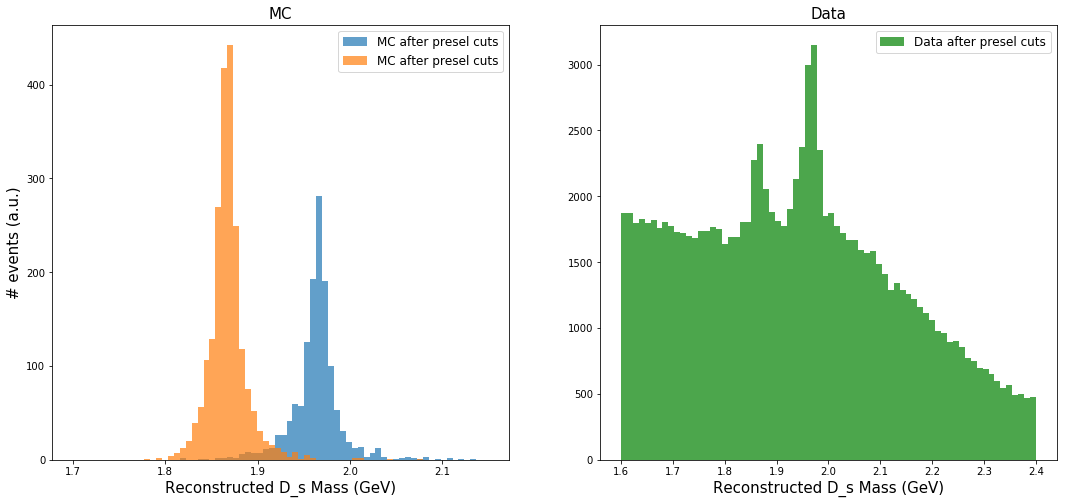

In [104]:
if l_flv[l_index]=='mu':
    lower_MC = 1.8
    upper_MC = 2.1
    lower_data = 1.0
    upper_data = 3.0
    
if l_flv[l_index]=='e':
    lower_MC = 1.7
    upper_MC = 2.15
    lower_data = 1.6
    upper_data = 2.4

#plt.suptitle('Reconstructed D_s mass', fontsize=15)
plt.subplot(1,2,1)
label="Ds_ConsD_M"
plt.title('MC', fontsize=15)
left_h_Ds=[MC_Ds_tuple_dict_presel_8[label][i][0]/1000 for i in range(len(MC_Ds_tuple_dict_presel_8["Ds_ConsD_M"]))]
label="Dplus_ConsD_M"
left_h_Dplus=[MC_Dplus_tuple_dict_presel_8[label][i][0]/1000 for i in range(len(MC_Dplus_tuple_dict_presel_8["Dplus_ConsD_M"]))]
plt.hist(left_h_Ds,alpha=0.7,bins=70,range=(lower_MC,upper_MC), label='MC after presel cuts',density=False);
plt.hist(left_h_Dplus,alpha=0.7,bins=70,range=(lower_MC,upper_MC), label='MC after presel cuts',density=False);
plt.legend(fontsize='12')
plt.ylabel('# events (a.u.)', fontsize=15)
plt.xlabel('Reconstructed D_s Mass (GeV)', fontsize=15)

label="Ds_ConsD_M"
plt.subplot(1,2,2)
plt.title('Data', fontsize=15)
right_h=[data_tuple_dict_presel_3[label][i][0]/1000 for i in range(len(data_tuple_dict_presel_3["Ds_ConsD_M"]))]
plt.hist(right_h,alpha=0.7,bins=70,range=(lower_data,upper_data), color='green',label='Data after presel cuts',density=False);
plt.legend(fontsize='12')
plt.xlabel('Reconstructed D_s Mass (GeV)', fontsize=15)
fig=plt.gcf()
fig.set_size_inches(18,8)
plt.savefig('/home/hep/davide/Rphipi/'+l_flv[l_index]+'_dataMC_after_presel.png', format='png', dpi=100)

In [105]:
Dplus_bf_phicut=np.float(MC_Dplus_tuple_dict_presel_8["Dplus_ConsD_M"].shape[0])
Ds_bf_phicut=np.float(MC_Ds_tuple_dict_presel_8["Ds_ConsD_M"].shape[0])

# PHI MASS CUT

In [106]:
if l_flv[l_index]=='mu':
    lower_phi_mass = 980
    upper_phi_mass = 1060
    
if l_flv[l_index]=='e':
    lower_phi_mass = 850
    upper_phi_mass = 1100
    
#Cut on phi mass

MC_Dplus_indices=[]
MC_Ds_indices=[]
data_indices=[]
        
for i in range(len(MC_Ds_tuple_dict_presel_8["Ds_ConsD_M"])):

    phi_m = MC_Ds_tuple_dict_presel_3["phi_M"][i]
    #fixing a window on the phi mass
    if lower_phi_mass<phi_m<upper_phi_mass:
        MC_Ds_indices.append(i)
        
for i in range(len(MC_Dplus_tuple_dict_presel_8["Dplus_ConsD_M"])):

    phi_m = MC_Dplus_tuple_dict_presel_3["phi_M"][i]
    #fixing a window on the phi mass
    if lower_phi_mass<phi_m<upper_phi_mass:
        MC_Dplus_indices.append(i)
        
for i in range(len(data_tuple_dict_presel_3["Ds_ConsD_M"])):

    phi_m = data_tuple_dict_presel_3["phi_M"][i]
    #fixing a window on the phi mass
    if lower_phi_mass<phi_m<upper_phi_mass:
        data_indices.append(i)

MC_Ds_tuple_dict_presel_9 ={}
MC_Dplus_tuple_dict_presel_9 ={}
data_tuple_dict_presel_4={}


for label in return_branches(data_index=1, mother_index=0, l_index=l_index, meson_index=0):  
    
    data_tuple_dict_presel_4[label] = data_tuple_dict_presel_3[label][data_indices]

for label in return_branches(data_index=0, mother_index=0, l_index=l_index, meson_index=0):  
    MC_Ds_tuple_dict_presel_9[label] = MC_Ds_tuple_dict_presel_8[label][MC_Ds_indices]

for label in return_branches(data_index=0, mother_index=1, l_index=l_index, meson_index=0):  
    MC_Dplus_tuple_dict_presel_9[label] = MC_Dplus_tuple_dict_presel_8[label][MC_Dplus_indices]

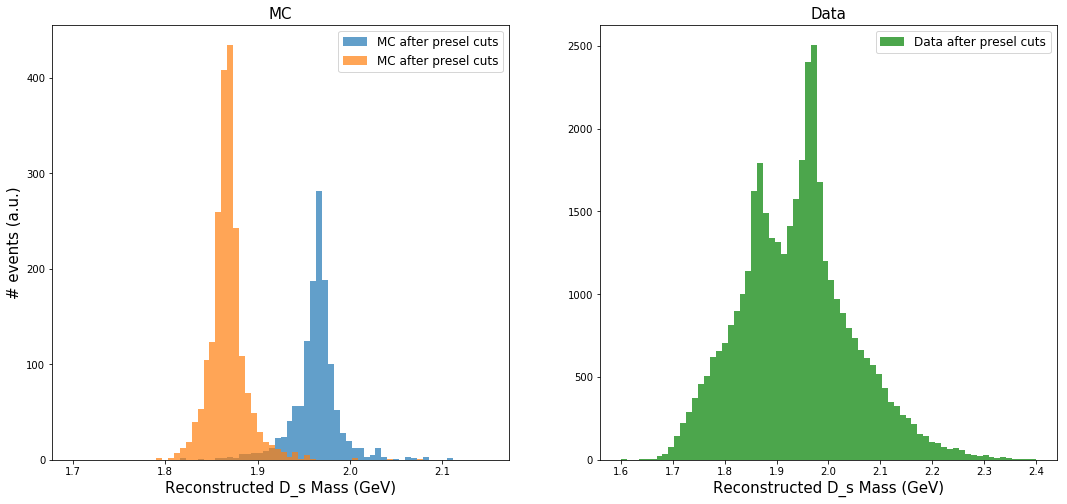

In [107]:
if l_flv[l_index]=='mu':
    lower_MC = 1.75
    upper_MC = 2.1
    lower_data = 1.65
    upper_data = 2.15
    
if l_flv[l_index]=='e':
    lower_MC = 1.7
    upper_MC = 2.15
    lower_data = 1.0
    upper_data = 3.0
    lower_data = 1.6
    upper_data = 2.4

#plt.suptitle('Reconstructed D_s mass', fontsize=15)
plt.subplot(1,2,1)
label="Ds_ConsD_M"
plt.title('MC', fontsize=15)
left_h_Ds=[MC_Ds_tuple_dict_presel_9[label][i][0]/1000 for i in range(len(MC_Ds_tuple_dict_presel_9["Ds_ConsD_M"]))]
label="Dplus_ConsD_M"
left_h_Dplus=[MC_Dplus_tuple_dict_presel_9[label][i][0]/1000 for i in range(len(MC_Dplus_tuple_dict_presel_9["Dplus_ConsD_M"]))]
plt.hist(left_h_Ds,alpha=0.7,bins=70,range=(lower_MC,upper_MC), label='MC after presel cuts',density=False);
plt.hist(left_h_Dplus,alpha=0.7,bins=70,range=(lower_MC,upper_MC), label='MC after presel cuts',density=False);
plt.legend(fontsize='12')
plt.ylabel('# events (a.u.)', fontsize=15)
plt.xlabel('Reconstructed D_s Mass (GeV)', fontsize=15)

label="Ds_ConsD_M"
plt.subplot(1,2,2)
plt.title('Data', fontsize=15)
right_h=[data_tuple_dict_presel_4[label][i][0]/1000 for i in range(len(data_tuple_dict_presel_4["Ds_ConsD_M"]))]
plt.hist(right_h,alpha=0.7,bins=70,range=(lower_data,upper_data), color='green',label='Data after presel cuts',density=False);
plt.legend(fontsize='12')
plt.xlabel('Reconstructed D_s Mass (GeV)', fontsize=15)
fig=plt.gcf()
fig.set_size_inches(18,8)
plt.savefig('/home/hep/davide/Rphipi/'+l_flv[l_index]+'_dataMC_after_presel_and_phi_mass_cut.png', format='png', dpi=100)

In [108]:
Dplus_af_phicut=np.float(MC_Dplus_tuple_dict_presel_9["Dplus_ConsD_M"].shape[0])
Ds_af_phicut=np.float(MC_Ds_tuple_dict_presel_9["Ds_ConsD_M"].shape[0])

In [109]:
eff_phi_cut_Ds=Ds_af_phicut/Ds_bf_phicut
eff_phi_cut_Dplus=Dplus_af_phicut/Dplus_bf_phicut
print("\n Phi mass cut efficiency on signal \n Dplus eff {0:.4g}, Ds eff {1:.4g}".format(eff_phi_cut_Dplus,eff_phi_cut_Ds))


 Phi mass cut efficiency on signal 
 Dplus eff 0.964, Ds eff 0.9657


# Boost Cross Checks

In [110]:
## pD = ppi + q in D rest frame
#
## Lambda D to lab:
#
#p_Dplus_lab, _, _, _, = get_4_momenta(MC_Dplus_tuple_dict_presel_9, 'Dplus')
#p_pi_lab, _, _, _,= get_4_momenta(MC_Dplus_tuple_dict_presel_9, 'pi')
#p_l_plus_lab, _, _, _, = get_4_momenta(MC_Dplus_tuple_dict_presel_9, l_flv[l_index]+'_plus')
#p_l_minus_lab, _, _, _, = get_4_momenta(MC_Dplus_tuple_dict_presel_9, l_flv[l_index]+'_minus')
#
#beta_D, beta_D_vec = get_boost_D_to_lab(MC_Dplus_tuple_dict_presel_9, mother_index=1)
#
#sigma_Es = []
#sigma_pxs = []
#sigma_pys = []
#sigma_pzs = []
#
#D_mass = []
#pi_mass =[]
#l_mass =[]
#
#for j in range(len(MC_Dplus_tuple_dict_presel_9["Dplus_ConsD_M"])):
#    
#
#    beta_D=r.TVector3(beta_D_vec[:,j][0], beta_D_vec[:,j][1], beta_D_vec[:,j][2])
#    lambda_lab_to_D=r.TLorentzRotation(-beta_D)
#
#    p_Dplus_lab_r = get_TLorentzVector(p_Dplus_lab, j)
#    p_pi_lab_r = get_TLorentzVector(p_pi_lab, j)
#    p_l_plus_lab_r = get_TLorentzVector(p_l_plus_lab, j)
#    p_l_minus_lab_r = get_TLorentzVector(p_l_minus_lab, j)
#
#    #boost it
#    p_Dplus_D = lambda_lab_to_D.VectorMultiplication(p_Dplus_lab_r)
#    p_pi_D = lambda_lab_to_D.VectorMultiplication(p_pi_lab_r)
#    p_l_plus_D = lambda_lab_to_D.VectorMultiplication(p_l_plus_lab_r)
#    p_l_minus_D = lambda_lab_to_D.VectorMultiplication(p_l_minus_lab_r)
#
#    #impose momentum conservation in D lab frame
#    total_p=p_l_minus_D+p_l_minus_D+p_pi_D
#    sigma_E, sigma_px, sigma_py, sigma_pz = [total_p.E()-p_Dplus_D.E(), total_p.Px()-p_Dplus_D.Px(), total_p.Py()-p_Dplus_D.Py(), total_p.Pz()-p_Dplus_D.Pz()]
#    
#    D_mass.append(p_Dplus_D.M2())
#    pi_mass.append(p_pi_D.M2())
#    
#    l_mass.append(p_l_minus_D.M2())
#    l_mass.append(p_l_plus_D.M2())
#    
#    sigma_Es.append(sigma_E)
#    sigma_pxs.append(sigma_px)
#    sigma_pys.append(sigma_py)
#    sigma_pzs.append(sigma_pz)    
#    
#sigma_Es = np.array(sigma_Es)
#sigma_pxs = np.array(sigma_pxs)
#sigma_pys = np.array(sigma_pys)
#sigma_pzs = np.array(sigma_pzs)
#
#D_mass = np.sqrt(np.array(D_mass))
#pi_mass = np.sqrt(np.array(pi_mass))
#l_mass = np.sqrt(np.array(l_mass))
#
#plt.subplot(2,2,1)
#plt.hist(sigma_Es, bins=50);
#plt.subplot(2,2,2)
#plt.hist(sigma_pzs, bins=50);
#plt.subplot(2,2,3)
#plt.hist(sigma_pxs, bins=50);
#plt.subplot(2,2,4)
#plt.hist(sigma_pys, bins=50);
#fig = plt.gcf()
#
#
#fig.set_size_inches(16,8)
#print(D_mass.mean(), pi_mass.mean(), l_mass.mean())

In [111]:
#beta_q = get_boost_D_to_q(MC_Dplus_tuple_dict_presel_9, l_index=l_index, mother_index=1)
#
#sigma_Es = []
#sigma_pxs = []
#sigma_pys = []
#sigma_pzs = []
#
#D_mass = []
#pi_mass =[]
#l_mass =[]
#
#for j in range(len(MC_Dplus_tuple_dict_presel_9["Dplus_ConsD_M"])):
#    
#    
#    beta_D=r.TVector3(beta_D_vec[:,j][0], beta_D_vec[:,j][1], beta_D_vec[:,j][2])
#    lambda_lab_to_D=r.TLorentzRotation(-beta_D)
#
#    p_Dplus_lab_r = get_TLorentzVector(p_Dplus_lab, j)
#    p_pi_lab_r = get_TLorentzVector(p_pi_lab, j)
#    p_l_plus_lab_r = get_TLorentzVector(p_l_plus_lab, j)
#    p_l_minus_lab_r = get_TLorentzVector(p_l_minus_lab, j)
#
#    #boost it from lab to D
#    p_Dplus_D = lambda_lab_to_D.VectorMultiplication(p_Dplus_lab_r)
#    p_pi_D = lambda_lab_to_D.VectorMultiplication(p_pi_lab_r)
#    p_l_plus_D = lambda_lab_to_D.VectorMultiplication(p_l_plus_lab_r)
#    p_l_minus_D = lambda_lab_to_D.VectorMultiplication(p_l_minus_lab_r)
#    
#    beta_q_r=r.TVector3(0,0, beta_q[j])
#    lambda_D_to_q=r.TLorentzRotation(beta_q_r)
#
#    #boost it from D to q
#    p_Dplus_q = lambda_D_to_q.VectorMultiplication(p_Dplus_D)
#    p_pi_q = lambda_D_to_q.VectorMultiplication(p_pi_D)
#    p_l_plus_q = lambda_D_to_q.VectorMultiplication(p_l_plus_D)
#    p_l_minus_q = lambda_D_to_q.VectorMultiplication(p_l_minus_D)
#
#    #impose momentum conservation in D lab frame
#    total_p=p_l_minus_q+p_l_minus_q+p_pi_q
#    sigma_E, sigma_px, sigma_py, sigma_pz = [total_p.E()-p_Dplus_q.E(), total_p.Px()-p_Dplus_q.Px(), total_p.Py()-p_Dplus_q.Py(), total_p.Pz()-p_Dplus_q.Pz()]
#
#    sigma_Es.append(sigma_E)
#    sigma_pxs.append(sigma_px)
#    sigma_pys.append(sigma_py)
#    sigma_pzs.append(sigma_pz)    
#
#    D_mass.append(p_Dplus_D.M2())
#    pi_mass.append(p_pi_D.M2())
#    
#    l_mass.append(p_l_minus_D.M2())
#    l_mass.append(p_l_plus_D.M2())
#    
#    
#sigma_Es = np.array(sigma_Es)
#sigma_pxs = np.array(sigma_pxs)
#sigma_pys = np.array(sigma_pys)
#sigma_pzs = np.array(sigma_pzs)
#
#D_mass = np.sqrt(np.array(D_mass))
#pi_mass = np.sqrt(np.array(pi_mass))
#l_mass = np.sqrt(np.array(l_mass))
#
#plt.subplot(2,2,1)
#plt.hist(sigma_Es, bins=50);
#plt.subplot(2,2,2)
#plt.hist(sigma_pzs, bins=50);
#plt.subplot(2,2,3)
#plt.hist(sigma_pxs, bins=50);
#plt.subplot(2,2,4)
#plt.hist(sigma_pys, bins=50);
#fig = plt.gcf()
#
#
#fig.set_size_inches(16,8)
#print(D_mass.mean(), pi_mass.mean(), l_mass.mean())

# Cos theta_l before cut on phi mass

In [112]:
costheta_Dplus_b=get_costheta_list(MC_Dplus_tuple_dict_presel_8, l_index=l_index, mother_index=1)
costheta_Ds_b=get_costheta_list(MC_Ds_tuple_dict_presel_8, l_index=l_index, mother_index=0)
costheta_MC_b=np.concatenate((costheta_Dplus_b,costheta_Ds_b),axis=0)


In [113]:
costheta_data_b=get_costheta_list(data_tuple_dict_presel_3, l_index=l_index, mother_index=0)

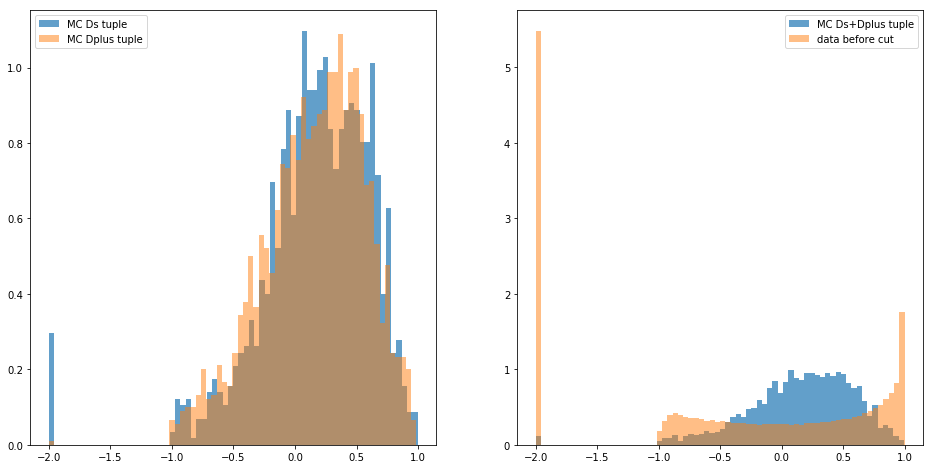

In [114]:
plt.subplot(1,2,1)
plt.hist(costheta_Ds_b,alpha=0.7,density=True,bins=70, label="MC Ds tuple");
plt.hist(costheta_Dplus_b,alpha=0.5,density=True,bins=70, label="MC Dplus tuple");
plt.legend()
plt.subplot(1,2,2)
plt.hist(costheta_MC_b,alpha=0.7,density=True,bins=70, label="MC Ds+Dplus tuple");
plt.hist(costheta_data_b,alpha=0.5,density=True,bins=70, label="data before cut");
plt.legend()
fig = plt.gcf()
fig.set_size_inches(16,8)

# Cos theta_l after cut on phi mass

In [115]:
costheta_Dplus=get_costheta_list(MC_Dplus_tuple_dict_presel_9, l_index=l_index, mother_index=1)
costheta_Ds=get_costheta_list(MC_Ds_tuple_dict_presel_9, l_index=l_index, mother_index=0)
costheta_MC=np.concatenate((costheta_Dplus,costheta_Ds),axis=0)
costheta_data=get_costheta_list(data_tuple_dict_presel_4, l_index=l_index, mother_index=0)

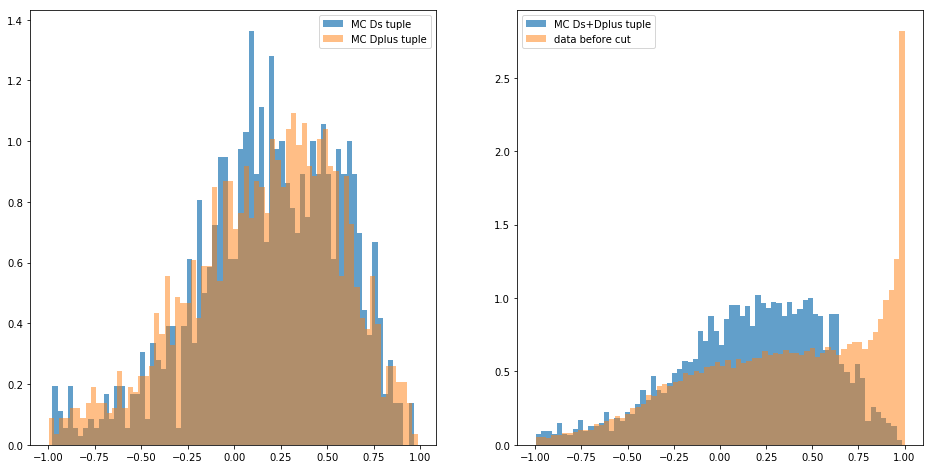

In [116]:
plt.subplot(1,2,1)
plt.hist(costheta_Ds,alpha=0.7,density=True,bins=70, label="MC Ds tuple");
plt.hist(costheta_Dplus,alpha=0.5,density=True,bins=70, label="MC Dplus tuple");
plt.legend()
plt.subplot(1,2,2)
plt.hist(costheta_MC,alpha=0.7,density=True,bins=70, label="MC Ds+Dplus tuple");
plt.hist(costheta_data,alpha=0.5,density=True,bins=70, label="data before cut");
plt.legend()
fig = plt.gcf()
fig.set_size_inches(16,8)

In [142]:
MC_Dplus_tuple_dict_presel_9["cos_thetal"]=costheta_Dplus
MC_Ds_tuple_dict_presel_9["cos_thetal"]=costheta_Ds
data_tuple_dict_presel_4["cos_thetal"]=costheta_data

In [143]:
MC_Dplus_tuple_dict_presel_10={}


indices=np.where(MC_Dplus_tuple_dict_presel_9["cos_thetal"]!=-2)[0]
labels = return_branches(data_index=0, mother_index=1, l_index=l_index, meson_index=0)+['cos_thetal']

for label in labels: 
    MC_Dplus_tuple_dict_presel_10[label]=MC_Dplus_tuple_dict_presel_9[label][indices]
    

MC_Ds_tuple_dict_presel_10={}


indices=np.where(MC_Ds_tuple_dict_presel_9["cos_thetal"]!=-2)[0]
labels = return_branches(data_index=0, mother_index=0, l_index=l_index, meson_index=0)+['cos_thetal']

for label in labels: 
    MC_Ds_tuple_dict_presel_10[label]=MC_Ds_tuple_dict_presel_9[label][indices]
    
data_tuple_dict_presel_5={}


indices=np.where(data_tuple_dict_presel_4["cos_thetal"]!=-2)[0]
labels = return_branches(data_index=1, mother_index=0, l_index=l_index, meson_index=0)+['cos_thetal']

for label in labels: 
    data_tuple_dict_presel_5[label]=data_tuple_dict_presel_4[label][indices] 

In [144]:
data_tuple_dict=data_tuple_dict_presel_5
MC_Ds_tuple_dict=MC_Ds_tuple_dict_presel_10
MC_Dplus_tuple_dict=MC_Dplus_tuple_dict_presel_10

In [150]:
if l_flv[l_index]=='mu':
    
    lower_Dplus_mass_data=1830
    lower_Dplus_mass_mc=lower_Dplus_mass_data
    
    upper_Dplus_mass=1910
    upper_Dplus_mass_mc=upper_Dplus_mass_data
    
    lower_Ds_mass = 1930
    lower_Ds_mass_mc=lower_Ds_mass_data
    
    upper_Ds_mass = 2010
    upper_Ds_mass_mc=upper_Ds_mass_data
    
    
if l_flv[l_index]=='e':
    
    lower_Dplus_mass_data=1810
    lower_Dplus_mass_mc=1790
    
    upper_Dplus_mass_data=1920
    upper_Dplus_mass_mc=1950

    lower_Ds_mass_data = 1920
    lower_Ds_mass_mc=1890
    upper_Ds_mass_data = 2020
    upper_Ds_mass_mc=2050

#Retrieve mc signal and data bkg events

data_bkg_indices=[]
MC_Ds_sig_indices=[]
MC_Dplus_sig_indices=[]


for i in range(len(data_tuple_dict["Ds_ConsD_M"])):
    
        m = data_tuple_dict["Ds_ConsD_M"][i]
        
    #selecting the out of signal regions
        if 0<m<lower_Dplus_mass_data or upper_Dplus_mass_data < m < lower_Ds_mass_data or upper_Ds_mass_data < m:
            data_bkg_indices.append(i)
            
for i in range(len(MC_Ds_tuple_dict["Ds_ConsD_M"])):
    
        m = MC_Ds_tuple_dict["Ds_ConsD_M"][i]
    
        if lower_Ds_mass_mc< m <upper_Ds_mass_mc:
            MC_Ds_sig_indices.append(i)  
            
for i in range(len(MC_Dplus_tuple_dict["Dplus_ConsD_M"])):
    
        m = MC_Dplus_tuple_dict["Dplus_ConsD_M"][i]
    
    #selecting the signal regions
        if lower_Dplus_mass_mc< m <upper_Dplus_mass_mc:
            MC_Dplus_sig_indices.append(i)
            

data_tuple_bkg={}
MC_Ds_tuple_sig ={}
MC_Dplus_tuple_sig ={}

labels=return_branches(data_index=1, mother_index=0, l_index=l_index, meson_index=0)+['cos_thetal']

for label in labels:    
    data_tuple_bkg[label] = data_tuple_dict[label][data_bkg_indices]

labels=return_branches(data_index=0, mother_index=0, l_index=l_index, meson_index=0)+['cos_thetal']
for label in labels:
    MC_Ds_tuple_sig[label] = MC_Ds_tuple_dict[label][MC_Ds_sig_indices]
    
labels=return_branches(data_index=0, mother_index=1, l_index=l_index, meson_index=0)+['cos_thetal']

for label in labels:  
    MC_Dplus_tuple_sig[label] = MC_Dplus_tuple_dict[label][MC_Dplus_sig_indices] 

In [151]:
with open('/disk/lhcb_data/davide/Rphipi/BDT_training/'+l_flv[l_index]+l_flv[l_index]+'/MC_for_BDT_training_Ds_'+l_flv[l_index]+l_flv[l_index]+'.pickle', 'wb') as handle:
    pickle.dump(MC_Ds_tuple_sig, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/disk/lhcb_data/davide/Rphipi/BDT_training/'+l_flv[l_index]+l_flv[l_index]+'/MC_for_BDT_training_Dplus_'+l_flv[l_index]+l_flv[l_index]+'.pickle', 'wb') as handle:
    pickle.dump(MC_Dplus_tuple_sig, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/disk/lhcb_data/davide/Rphipi/BDT_training/'+l_flv[l_index]+l_flv[l_index]+'/data_for_BDT_training_'+l_flv[l_index]+l_flv[l_index]+'.pickle', 'wb') as handle:
    pickle.dump(data_tuple_bkg, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/disk/lhcb_data/davide/Rphipi/MC/for_fit/'+l_flv[l_index]+l_flv[l_index]+'/MC_Ds_'+l_flv[l_index]+l_flv[l_index]+'.pickle', 'wb') as handle:
    pickle.dump(MC_Ds_tuple_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/disk/lhcb_data/davide/Rphipi/MC/for_fit/'+l_flv[l_index]+l_flv[l_index]+'/MC_Dplus_'+l_flv[l_index]+l_flv[l_index]+'.pickle', 'wb') as handle:
    pickle.dump(MC_Dplus_tuple_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/disk/lhcb_data/davide/Rphipi/data_for_BDT_selection/'+l_flv[l_index]+l_flv[l_index]+'/data_for_BDT_selection_'+l_flv[l_index]+l_flv[l_index]+'.pickle', 'wb') as handle:
    pickle.dump(data_tuple_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [152]:
data_tuple_bkg["Ds_ConsD_M"].shape[0]

12244

In [153]:
MC_Dplus_tuple_sig["Dplus_ConsD_M"].shape[0]

2025

In [154]:
MC_Ds_tuple_sig["Ds_ConsD_M"].shape[0]

1262